In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer ,TfidfTransformer ,CountVectorizer
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings; warnings.simplefilter('ignore')

# Lista 02
**Exercı́cios**

* Neste exercício você irá implementar algumas técnicas vistas em aula para um banco de dados de filmes (https://www.dropbox.com/s/6ltw600uoiynd3t/TMDb_updated.CSV.zip?dl=0). O objetivo aqui é conseguir criar uma função que consiga predizer para onde uma a nota média de um filme (vote average) com base em seu resumo (overview).
1. Leia o banco e faça o processamento necessário para transformar os textos em uma matriz documento-termo. Divida o conjunto fornecido em treinamento, validação e teste, justificando as porcentagens escolhidas para cada grupo. Utilizaremos o conjunto de treinamento e validação para ajustar os modelos. O conjunto de teste será utilizado para testar seu desempenho.
2. Utilize validação cruzada (data splitting) para escolher o melhor k. Plote k vs Risco estimado. Utilizando o conjunto de teste, estime o risco (e seu erro padrão) do KNN para o melhor k.
3. Ajuste uma regressão linear para os dados usando o conjunto de treinamento mais o de validação via lasso (lembre-se que a função que ajusta o lasso no R já faz validação cruzada automaticamente: ao contrário do KNN, neste caso nãoo é necessário separar os dados em treinamento e validação). Qual o lambda escolhido?Plote lambda vs Risco estimado. Quais foram as variáveis mais importantes no ajuste (mostre os coeficientes estimados)? Utilizando o conjunto de teste, estime o risco (e seu erro padrão) do lasso para o melhor lambda.
4. Ajuste uma floresta aleatória para os dados usando o conjunto de treinamento mais o de validação (lembre-se que praticamente não há tuning em florestas). Estime o risco com o teste. Faça um gráfico de importância de covariáveis. Como as importâncias se comparam com as obtidas pelo estimador linear?
5. Ajuste boosting com xgboost, catboost ou lightboost, com número de iterações escolhidos via early-stopping no conjunto de validação. Estime o risco com o teste. Faça um gráfico de importância de covariáveis. Como as importâncias se comparam com as obtidas pelo estimador linear e pela floresta?
6. Ajuste uma rede neural com early-stopping. Estime o risco com o teste. (Pós-graduação) Adicione drop-out na rede. O desempenho melhora?
7. (Pós-graduação) Ajuste um kernel ridge regression com λ escolhido utilizando o conjunto de validação. Estime o risco (e seu erro padrão) com o teste.
8. Plote os valores preditos versus os valores observados para o conjunto de teste em cada um dos métodos. Inclua a reta identidade.
9. Qual modelo teve melhores resultados? Leve em conta os erros-padrão nessa análise

In [2]:
df = pd.read_csv('tmdb.csv').drop('Unnamed: 0' ,axis=1)

In [3]:
df

,title,overview,original_language,vote_count,vote_average
0,Ad Astra,"The near future, a time when both hope and har...",en,2853,5.9
1,Bloodshot,"After he and his wife are murdered, marine Ray...",en,1349,7.2
2,Bad Boys for Life,Marcus and Mike are forced to confront new thr...,en,2530,7.1
3,Ant-Man,Armed with the astonishing ability to shrink i...,en,13611,7.1
4,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",en,3542,5.9
...,...,...,...,...,...
9995,Cargo,The story of CARGO takes place on rusty space-...,de,225,5.9
9996,The Good Night,"Gary, a musician, is trapped in an unhappy rel...",en,67,5.6
9997,The World Is Yours,"To escape his life of crime, a Paris drug deal...",fr,234,7.1
9998,The Grand Seduction,A small fishing village must procure a local d...,en,169,6.7


# Verificando dados faltantes

In [4]:
df.isnull().sum()

title                 0
overview             30
original_language     0
vote_count            0
vote_average          0
dtype: int64

In [5]:
# retirando valores faltantes
df.dropna(inplace=True)

In [6]:
df

,title,overview,original_language,vote_count,vote_average
0,Ad Astra,"The near future, a time when both hope and har...",en,2853,5.9
1,Bloodshot,"After he and his wife are murdered, marine Ray...",en,1349,7.2
2,Bad Boys for Life,Marcus and Mike are forced to confront new thr...,en,2530,7.1
3,Ant-Man,Armed with the astonishing ability to shrink i...,en,13611,7.1
4,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",en,3542,5.9
...,...,...,...,...,...
9995,Cargo,The story of CARGO takes place on rusty space-...,de,225,5.9
9996,The Good Night,"Gary, a musician, is trapped in an unhappy rel...",en,67,5.6
9997,The World Is Yours,"To escape his life of crime, a Paris drug deal...",fr,234,7.1
9998,The Grand Seduction,A small fishing village must procure a local d...,en,169,6.7


# Histrograma vote_count

(array([8.68678885e-04, 1.40472316e-04, 6.22194243e-05, 3.30241560e-05,
        2.34519369e-05, 1.71103417e-05, 9.33291364e-06, 5.74333147e-06,
        6.58090065e-06, 4.54680408e-06, 4.54680408e-06, 3.23062395e-06,
        1.91444382e-06, 2.63236026e-06, 2.27340204e-06, 1.31618013e-06,
        1.67513835e-06, 1.07687465e-06, 8.37569173e-07, 7.17916434e-07,
        2.39305478e-07, 3.58958217e-07, 1.19652739e-07, 0.00000000e+00,
        2.39305478e-07, 2.39305478e-07, 2.39305478e-07, 0.00000000e+00,
        0.00000000e+00, 1.19652739e-07]),
 array([    0.        ,   838.26666667,  1676.53333333,  2514.8       ,
         3353.06666667,  4191.33333333,  5029.6       ,  5867.86666667,
         6706.13333333,  7544.4       ,  8382.66666667,  9220.93333333,
        10059.2       , 10897.46666667, 11735.73333333, 12574.        ,
        13412.26666667, 14250.53333333, 15088.8       , 15927.06666667,
        16765.33333333, 17603.6       , 18441.86666667, 19280.13333333,
        20118.4       

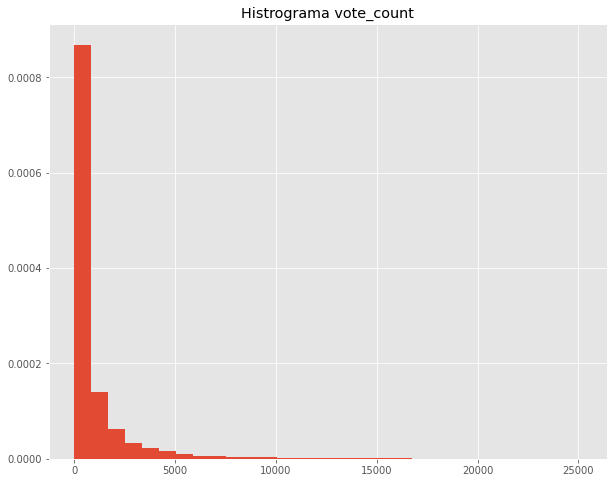

In [7]:
plt.figure(figsize=(10, 8))
plt.title('Histrograma vote_count')
plt.hist(df['vote_count'], density=True, bins=30) 

# Histrograma vote_average

(array([6.86058175e-02, 0.00000000e+00, 0.00000000e+00, 3.00902708e-04,
        0.00000000e+00, 3.00902708e-04, 6.01805416e-04, 1.20361083e-03,
        2.40722166e-03, 2.70812437e-03, 5.11534604e-03, 1.17352056e-02,
        3.24974925e-02, 4.18254764e-02, 6.19859579e-02, 1.70010030e-01,
        1.94684052e-01, 2.76228686e-01, 4.87763290e-01, 3.74924774e-01,
        3.40621866e-01, 4.08324975e-01, 2.46138415e-01, 1.54062187e-01,
        9.38816449e-02, 1.65496489e-02, 3.61083250e-03, 1.50451354e-03,
        6.01805416e-04, 1.80541625e-03]),
 array([ 0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
         1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ,
         3.33333333,  3.66666667,  4.        ,  4.33333333,  4.66666667,
         5.        ,  5.33333333,  5.66666667,  6.        ,  6.33333333,
         6.66666667,  7.        ,  7.33333333,  7.66666667,  8.        ,
         8.33333333,  8.66666667,  9.        ,  9.33333333,  9.66666667,
        10.     

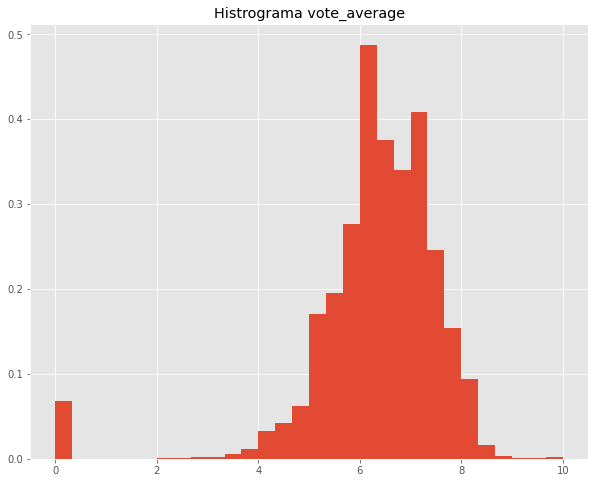

In [8]:
plt.figure(figsize=(10, 8))
plt.title('Histrograma vote_average')
plt.hist(df['vote_average'], density=True, bins=30) 

## Alguns filmes não receberam nenhum voto. Com isso, receberam nota 0. Para obter melhor resultado esses filmes serão ignorados.

In [9]:
df = df[df['vote_count']!=0]

array([[<AxesSubplot:title={'center':'vote_count'}>,
        <AxesSubplot:title={'center':'vote_average'}>]], dtype=object)

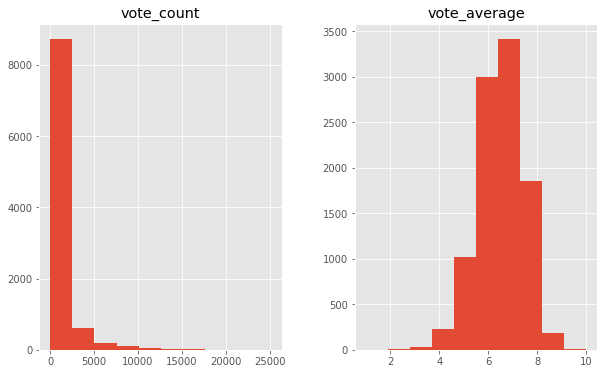

In [10]:
df.hist(figsize=(10, 6))

In [11]:
df.corr()

,vote_count,vote_average
vote_count,1.000000,0.243199
vote_average,0.243199,1.000000


## original_language

<AxesSubplot:>

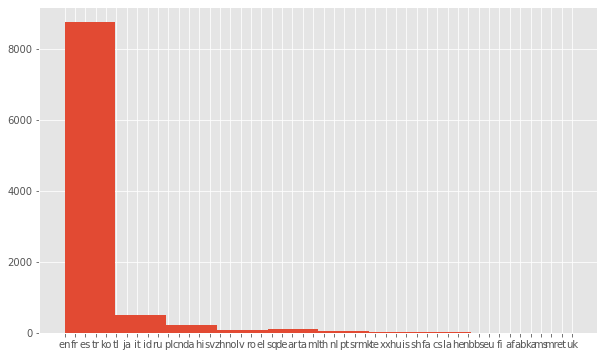

In [12]:
df['original_language'].hist(figsize=(10, 6))

## Transformando Overview

In [23]:
df.shape

(9742, 5)

In [27]:
#tfidfvectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')

In [28]:
vectorizer = CountVectorizer(min_df=5, ngram_range=(1, 2), stop_words='english')

In [31]:
overview=df['overview']

In [33]:
vector = vectorizer.fit_transform(overview)

In [34]:
print(vectorizer.vocabulary_)

{'near': 5759, 'future': 3585, 'time': 8520, 'hope': 4167, 'hardships': 3938, 'drive': 2629, 'humanity': 4231, 'look': 5067, 'stars': 7989, 'mysterious': 5697, 'phenomenon': 6283, 'destroy': 2348, 'life': 4932, 'planet': 6356, 'earth': 2703, 'astronaut': 657, 'roy': 7221, 'undertakes': 8825, 'mission': 5547, 'space': 7862, 'perils': 6248, 'uncover': 8809, 'truth': 8731, 'lost': 5096, 'expedition': 3048, 'decades': 2220, 'boldly': 1066, 'faced': 3108, 'emptiness': 2817, 'silence': 7674, 'search': 7407, 'unknown': 8868, 'near future': 5762, 'planet earth': 6357, 'uncover truth': 8810, 'wife': 9231, 'murdered': 5669, 'marine': 5296, 'ray': 6805, 'resurrected': 7051, 'team': 8349, 'scientists': 7386, 'enhanced': 2862, 'superhuman': 8195, 'killing': 4738, 'machine': 5173, 'trains': 8624, 'fellow': 3257, 'super': 8191, 'soldiers': 7794, 'recall': 6846, 'memories': 5412, 'flood': 3400, 'remembers': 6959, 'man': 5235, 'killed': 4733, 'breaks': 1140, 'facility': 3110, 'revenge': 7080, 'discover

In [18]:
print(vector.shape)
print(type(vector))

(9742, 9483)
<class 'numpy.ndarray'>


In [40]:
vector

<9742x9483 sparse matrix of type '<class 'numpy.int64'>'
	with 223400 stored elements in Compressed Sparse Row format>

In [41]:
pd.DataFrame(vector.toarray() , columns=vectorizer.get_feature_names())

,000,000 years,007,10,10 000,10 year,10 years,100,11,11 year,...,zany,zealand,zero,zeus,zoe,zombie,zombies,zone,zones,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
print("Esparsidade: ", ((vector.todense() == 0).sum()/vector.todense().size)*100, "%")

Esparsidade:  99.75818162802564 %
